In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_models import *
from skimage import metrics

/net/dali/home/mscbio/aar126/.conda/envs/dehaze/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /net/dali/home/mscbio/aar126/.conda/envs/dehaze/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
_, models_avail = getHelp()

Models available: 
 LightDehazeNet 
 LightDehazeNet_KL 
 LighDehazeNet_GL 
 LightDehazeNet_MI 
 LightDehaze_Net_Attn, LightDehazeNet_Attn_Conv, LightDehazeNet_Attn_Conv_Big


In [3]:
models_avail

['LightDehazeNet',
 'LightDehazeNet_KL',
 'LighDehazeNet_GL',
 'LightDehazeNet_MI',
 'LightDehazeNet_Attn',
 'LightDehazeNet_Attn_Conv',
 'LightDehazeNet_Attn_Conv_Big']

In [ ]:

# current folder
cur_folder = 'src'

# storing paths as string
main_dir = str(os.getcwd()[:-len(cur_folder)])

weight_dir = main_dir + 'weights_batch4/'
dirs = {models_avail[0] : weight_dir + str.lower(models_avail[0]) + '/', 
        models_avail[1] : weight_dir + str.lower(models_avail[0]) + '_KL/',
       models_avail[2] : weight_dir + str.lower(models_avail[0]) + '_GL/',
        #models_avail[3] : weight_dir + str.lower(models_avail[0]) + '_MI/',
       models_avail[4] : weight_dir + str.lower(models_avail[4]) + '/', 
        models_avail[5] : weight_dir + str.lower(models_avail[5]) + '/',
       models_avail[6] : weight_dir + str.lower(models_avail[6]) + '/'}

In [ ]:
files = ['per_epoch_train.csv', 'per_epoch_val.csv', 'train_loss_all.csv', 'val_loss_all.csv']

In [ ]:
mdl_losses = {x : [] for x in dirs}

losses = pd.DataFrame()

for m in list(dirs.keys()):
    mdl_losses[m] = {'train': pd.read_csv(dirs[m] + files[0]), 'val':pd.read_csv(dirs[m] + files[1])}
    losses = losses.append(mdl_losses[m], ignore_index = True)

In [ ]:

losses_long = pd.DataFrame()

for m in list(dirs.keys()):
    mdl_losses[m] = {'train': pd.read_csv(dirs[m] + files[2]), 'val':pd.read_csv(dirs[m] + files[1])}
    losses_long = losses_long.append(mdl_losses[m], ignore_index = True)

In [ ]:
# train batch size is 9800
losses_long['train'][0]

In [ ]:
# figure 1: training loss vs validation loss at each epoch

# for i, k in enumerate(dirs):
# not ready yet
for x in range(len(list(mdl_losses.keys()))):
    fig, axs = plt.subplots(2,1)
    axs[0].plot(losses['train'][x]['0'], label = "train")
    axs[1].plot(losses['val'][x]['0'], label = "val")
#     plt.yscale('log')
    plt.legend()
    
    plt.show()

In [ ]:
# img comparison
losses

In [ ]:
# load training/validation data
img_dirs = {'hazy' : main_dir + 'reside/hazy/', 'clear' : main_dir + 'reside/clear/'}
train_data, validation_data, test_data = preparing_training_data(img_dirs['clear'], img_dirs['hazy'])

In [ ]:
weight_dirs_pth = {models_avail[0] : weight_dir + str.lower(models_avail[0]) + '/39_', 
        models_avail[1] : weight_dir + str.lower(models_avail[0]) + '_KL/39_',
       models_avail[2] : weight_dir + str.lower(models_avail[0]) + '_GL/39_',
        models_avail[3] : weight_dir + str.lower(models_avail[0]) + '_MI/39_',
       models_avail[4] : weight_dir + str.lower(models_avail[4]) + '/39_', 
        models_avail[5] : weight_dir + str.lower(models_avail[5]) + '/39_',
       models_avail[6] : weight_dir + str.lower(models_avail[6]) + '/39_'}

mdls = {'lhd' : LightDehazeNet(weight_dirs_pth[list(dirs.keys())[0]]), 
        'KL' : LightDehazeNet_KL(weight_dirs_pth[list(dirs.keys())[1]]), 
        'GL' : LightDehazeNet_GL(weight_dirs_pth[list(dirs.keys())[2]]),
#         'MI' : LightDehazeNet_MI(weight_dirs_pth[list(dirs.keys())[3]]),
        'attn': LightDehazeNet_Attn(weight_dirs_pth[list(dirs.keys())[3]]),
        'attn_conv': LightDehazeNet_Attn_Conv(weight_dirs_pth[list(dirs.keys())[4]]),
        'attn_conv_big': LightDehazeNet_Attn_Conv_Big(weight_dirs_pth[list(dirs.keys())[5]])}



In [ ]:
# iterate through test data
psnr_dict = {x : [] for x in list(mdls.keys())}
ssim_dict = {x : [] for x in list(mdls.keys())}
for i, [clear, hazy] in enumerate(test_data):
    
    hazy_image = np.array(Image.open(hazy))
    clear_image = np.array(Image.open(clear))

    for m in list(psnr_dict.keys()):
        
        dehazed = (mdls[m].image_haze_removel(hazy_image))[0, :, : :].permute(1, 2, 0)
        
        psnr_dict[m].append(metrics.peak_signal_noise_ratio(clear_image, dehazed.cpu().data.numpy()))
        ssim_dict[m].append(metrics.structural_similarity(clear_image, dehazed.cpu().data.numpy() ,multichannel = True))
        
        
#         psnr_dict[m].append(cv2.PSNR(dehazed.cpu().data.numpy(), clear_image))
#         psnr_dict[m].append(compute_psnr(dehazed.cpu().data.numpy(), clear_image))


In [29]:
psnr_df = pd.DataFrame.from_dict(psnr_dict, orient="index")
psnr_df.to_csv('psnr_round3_df.csv')

ssim_df = pd.DataFrame.from_dict(ssim_dict, orient="index")
ssim_df.to_csv('ssim_round3_df.csv')

In [30]:
for p, s in zip(list(psnr_dict.keys()), list(ssim_dict.keys())):
    print(p)
    print('psnr:' + str(np.array(psnr_dict[p]).mean()))
    print(' ssim:' + str(np.array(ssim_dict[p]).mean()))

lhd
psnr:6.674236547110356
 ssim:0.031018349965691753
KL
psnr:6.737231510963042
 ssim:0.06602627831720989
GL
psnr:6.674236817357643
 ssim:0.031018351900021383
attn
psnr:6.674236548090596
 ssim:0.03101834996854691
attn_conv
psnr:6.67423654510772
 ssim:0.031018349960662897
attn_conv_big
psnr:6.674236545485651
 ssim:0.031018349961363757


In [28]:
for p, s in zip(list(psnr_dict.keys()), list(ssim_dict.keys())):
    print(p)
    print('psnr:' + str(np.array(psnr_dict[p]).mean()))
    print(' ssim:' + str(np.array(ssim_dict[p]).mean()))

lhd
psnr:18.151829456283792
 ssim:0.8030419931980964
KL
psnr:18.245283072815468
 ssim:0.8178019462800099
GL
psnr:17.99771760570524
 ssim:0.7928901999291945
attn
psnr:18.12478820565566
 ssim:0.800988503141274
attn_conv
psnr:18.217716933505056
 ssim:0.8081946791743859
attn_conv_big
psnr:18.012484783549244
 ssim:0.793916293242307


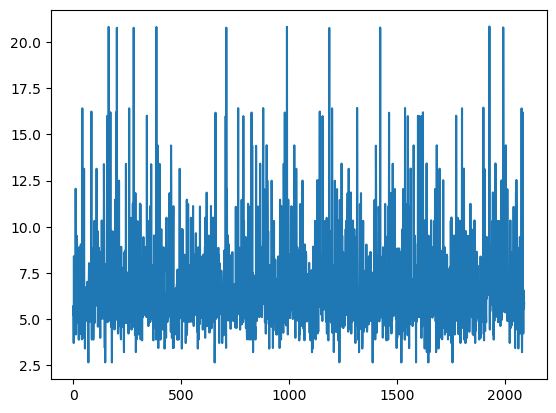

/tmp/ipykernel_1806579/2333041959.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  plt.plot(pd.Series(psnr_dict[m]), label = m)


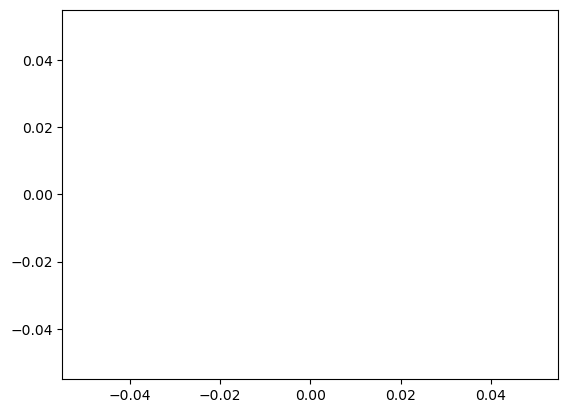

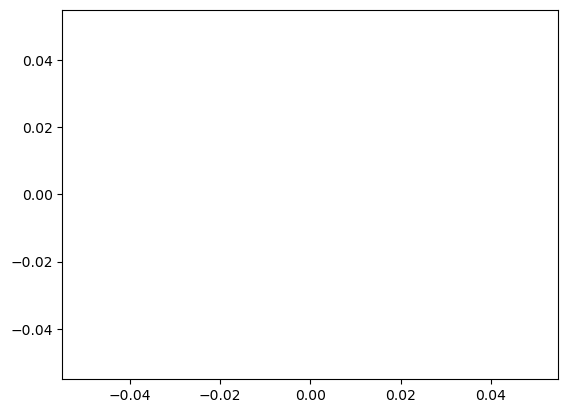

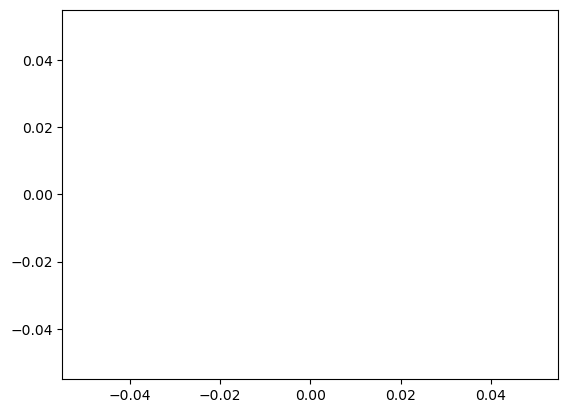

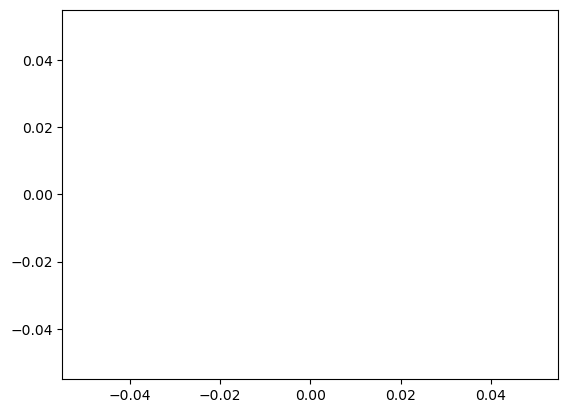

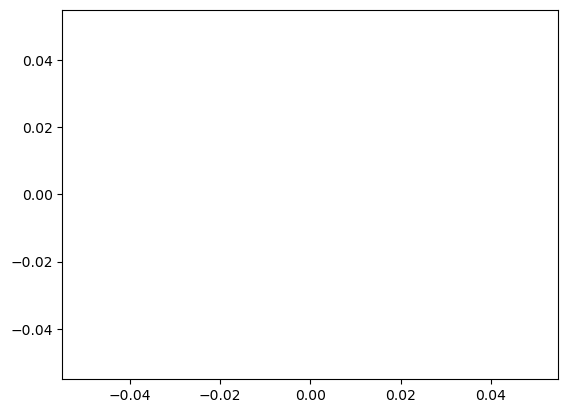

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


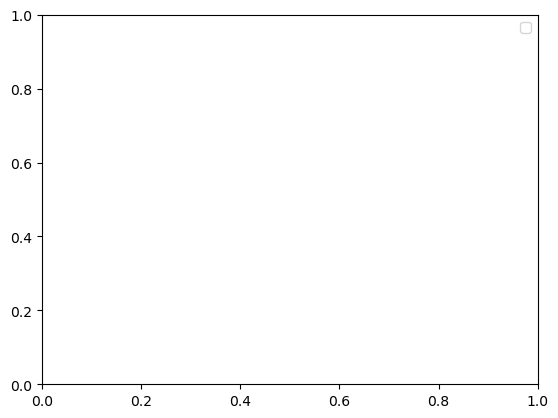

In [12]:
# go through training data for each model:
plt.figure()

for m in list(psnr_dict.keys()):
    plt.plot(pd.Series(psnr_dict[m]), label = m)
    plt.show()
plt.legend()


In [ ]:

for m in list(psnr_dict.keys()):
#     plt.plot(pd.Series(psnr_dict[m]), label = m)
    
    print(m + str(np.mean(psnr_dict[m])))



In [ ]:
for x in range(len(list(mdl_losses.keys()))):
    plt.figure()
    plt.plot(losses['train'][x]['0'], label = "train")
    plt.plot(losses['val'][x]['0'], label = "val")
    plt.legend()
    plt.show()

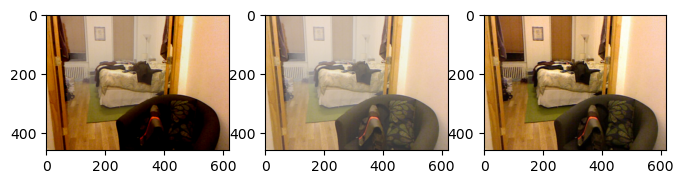

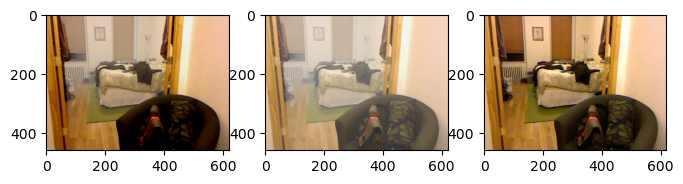

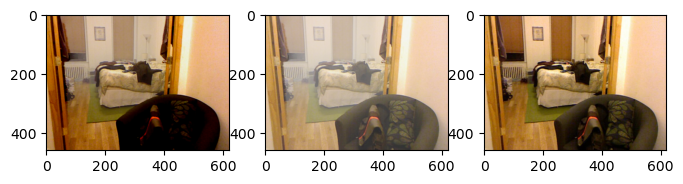

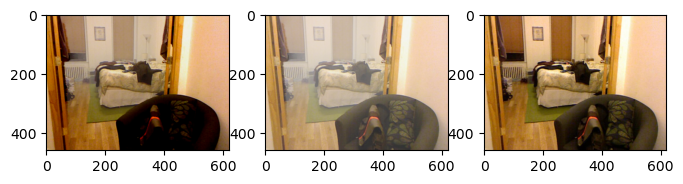

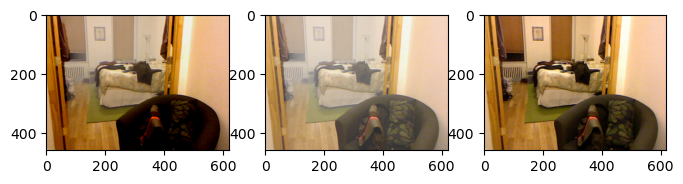

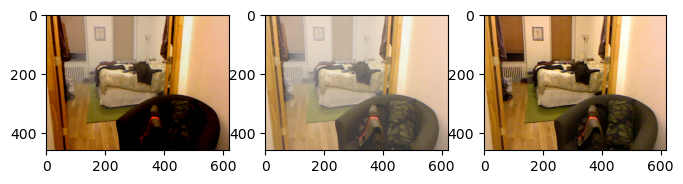

In [34]:
hazy_image = np.array(Image.open(test_data[2][1]))
clear_image = np.array(Image.open(test_data[2][0]))

for m in list(psnr_dict.keys()):
    fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (8, 8))
    dehazed = (mdls[m].image_haze_removel(hazy_image))[0, :, : :].permute(1, 2, 0)
    ax0.imshow(dehazed.cpu().data.numpy())
    ax1.imshow(hazy_image)
    ax2.imshow(clear_image)

In [8]:
from DCP import *
import numpy as np

/tmp/ipykernel_3457329/2170487764.py:33: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  val = round(metrics.peak_signal_noise_ratio(clear_image, dehazed.cpu().data.numpy()), 3)


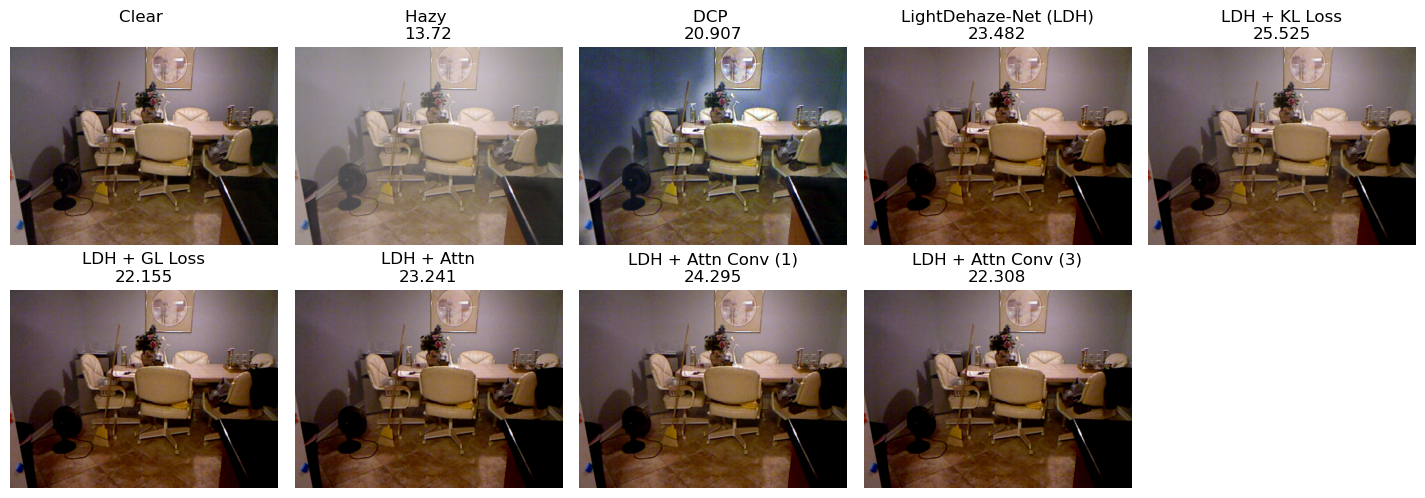

In [78]:
# pick a random image
p_img = test_data[200]

hazy_image = np.array(Image.open(p_img[1]))
clear_image = np.array(Image.open(p_img[0]))/255.0

clear_imagec = np.array(Image.open(p_img[0]))

# hazy + clear + DCP + 6
fig, axs = plt.subplots(2, 5, figsize = (15, 5))
plt.tight_layout()
axs.flat[0].imshow(clear_image)
axs.flat[0].axis('off')
axs.flat[0].set_title('Clear \n')

axs.flat[1].imshow(hazy_image)
axs.flat[1].axis('off')
hval = round(metrics.peak_signal_noise_ratio(clear_imagec, hazy_image), 3)
axs.flat[1].set_title('Hazy \n'+ f'{hval}')

axs.flat[2].imshow(dcp_all(hazy_image))
axs.flat[2].axis('off')
dcpval = round(metrics.peak_signal_noise_ratio(clear_imagec, dcp_all(hazy_image)), 3)
axs.flat[2].set_title('DCP \n' + f'{dcpval}')

captions = ['LightDehaze-Net (LDH)', 'LDH + KL Loss', 'LDH + GL Loss', 'LDH + Attn', 'LDH + Attn Conv (1)', 'LDH + Attn Conv (3)' ]
ax_count = 3
for m, c in zip(list(mdls.keys()), captions):

    dehazed = (mdls[m].image_haze_removel(hazy_image))[0, :, : :].permute(1, 2, 0)
    axs.flat[ax_count].imshow(dehazed.cpu().data.numpy(), label = m)
    axs.flat[ax_count].axis('off')
    val = round(metrics.peak_signal_noise_ratio(clear_image, dehazed.cpu().data.numpy()), 3)
    axs.flat[ax_count].set_title(c + '\n' + f'{val}')

    ax_count += 1

fig.delaxes(axs.flat[-1])
fig.subplots_adjust(wspace=0)
plt.show()
# plt.close()


In [79]:
fig.tight_layout()
fig.savefig('sidebysidet.png', dpi = 300, bbox_inches = 'tight')

In [80]:
dcp_psnr = []
dcp_ssim = []

for i, [clear, hazy] in enumerate(test_data):
    h = np.array(Image.open(hazy))
    c = np.array(Image.open(clear))
    dcp_psnr.append(metrics.peak_signal_noise_ratio(c, dcp_all(h)))
    dcp_ssim.append(metrics.structural_similarity(c, dcp_all(h) ,multichannel = True))

/tmp/ipykernel_3457329/427856189.py:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  dcp_ssim.append(metrics.structural_similarity(c, dcp_all(h) ,multichannel = True))


KeyboardInterrupt: 